In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
from transformers import BertModel, BertTokenizer

In [2]:
def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = parsed_text.replace("\t", "")
    parsed_text = parsed_text.replace("!", "")
    parsed_text = parsed_text.replace(" RT : ", "")
    parsed_text = parsed_text.replace("RT ", "")
    parsed_text = parsed_text.strip()
    return parsed_text


dataset_path = "/home/sestek/workspace/medium/cpp_series/data/hate-speech-and-offensive-language/data/labeled_data.csv"
all_df = pd.read_csv(dataset_path)
for label in ["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"]:
    del all_df[label]
all_df.tweet = all_df.tweet.apply(preprocess)
all_df = all_df.sample(frac=1).reset_index(drop=True)

print(all_df.head())

train_limit = int(len(all_df) * 0.8)
train_df, test_df = all_df[:train_limit], all_df[train_limit:]

#train_df = train_df[:1000]
#test_df = test_df[:1000]

   class                                              tweet
0      1  ' You gottttta be a mad a madddd niggah &#1041...
1      1                                      Obama's bitch
2      1       &#8220;: Sexy bitch, hope she bout it&#8221;
3      1  one charlotte store, but of course they are fa...
4      1  &#8220;: Did I just start crying? &#128553;&#1...


In [3]:
class Model(nn.Module):
    def __init__(self, dropout=0.5):
        super(Model, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased', torchscript=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)
        return x


model = Model()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', torchscript=True)

vocab_file = open("bert_cased_vocab.txt", "w")
for i, j in tokenizer.get_vocab().items():
    vocab_file.write(f"{i} {j}\n")
vocab_file.close()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]

        text = tokenizer(sample.tweet, padding='max_length', max_length = 32, truncation=True, return_tensors="pt")
        label = sample["class"]

        return text, label


train_dataset = Dataset(train_df)
test_dataset = Dataset(test_df)

datasets = dict()
datasets["train"] = train_dataset
datasets["test"] = test_dataset

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

dataloaders = dict()
dataloaders["train"] = train_dataloader
dataloaders["test"] = test_dataloader

In [5]:
device = torch.device("cuda:0")

model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-6)

In [6]:
epochs = 5

losses = {"train": [], "test": []}
accuracies = {"train": [], "test": []}

for epoch_num in range(epochs):
    for phase in ["train", "test"]:

        if phase == "train":
            model.train()
        else:
            model.eval()

        total_loss, total_acc = 0, 0
        for batch_input, batch_label in tqdm(dataloaders[phase], desc=phase):
            batch_label = batch_label.to(device)
            batch_attention_mask = batch_input['attention_mask'].to(device)
            batch_input_ids = batch_input['input_ids'].squeeze(1).to(device)

            output = model(batch_input_ids, batch_attention_mask)
        
            batch_loss = criterion(output, batch_label.long())
            total_loss += batch_loss.item()
            total_acc += (output.argmax(dim=1) == batch_label).sum().item()

            if phase == "train":
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
        
        losses[phase].append(total_loss / len(datasets[phase]))
        accuracies[phase].append(total_acc / len(datasets[phase]))

    print(losses)
    print(accuracies)

test: 100%|██████████| 78/78 [00:11<00:00,  6.64it/s]


{'train': [0.04200127070851779], 'test': [0.006417224658264228]}
{'train': [0.7251588822757995], 'test': [0.8696792414766996]}


test: 100%|██████████| 78/78 [00:11<00:00,  6.51it/s]


{'train': [0.04200127070851779, 0.02460790693145112], 'test': [0.006417224658264228, 0.005384523105135554]}
{'train': [0.7251588822757995, 0.8701704832038737], 'test': [0.8696792414766996, 0.8922735525519467]}


test: 100%|██████████| 78/78 [00:12<00:00,  6.28it/s]


{'train': [0.04200127070851779, 0.02460790693145112, 0.021683075731421208], 'test': [0.006417224658264228, 0.005384523105135554, 0.005109251239907244]}
{'train': [0.7251588822757995, 0.8701704832038737, 0.8895894280238071], 'test': [0.8696792414766996, 0.8922735525519467, 0.8977203954004438]}


test: 100%|██████████| 78/78 [00:12<00:00,  6.21it/s]


{'train': [0.04200127070851779, 0.02460790693145112, 0.021683075731421208, 0.019944477439660255], 'test': [0.006417224658264228, 0.005384523105135554, 0.005109251239907244, 0.005059011205384537]}
{'train': [0.7251588822757995, 0.8701704832038737, 0.8895894280238071, 0.8994754362957732], 'test': [0.8696792414766996, 0.8922735525519467, 0.8977203954004438, 0.8991325398426467]}


test: 100%|██████████| 78/78 [00:12<00:00,  6.16it/s]

{'train': [0.04200127070851779, 0.02460790693145112, 0.021683075731421208, 0.019944477439660255, 0.018718791462016535], 'test': [0.006417224658264228, 0.005384523105135554, 0.005109251239907244, 0.005059011205384537, 0.004806594470347131]}
{'train': [0.7251588822757995, 0.8701704832038737, 0.8895894280238071, 0.8994754362957732, 0.904267123978614], 'test': [0.8696792414766996, 0.8922735525519467, 0.8977203954004438, 0.8991325398426467, 0.9017550938067379]}


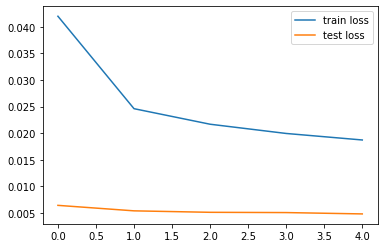

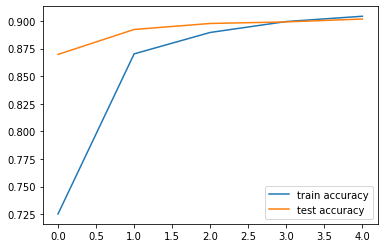

In [7]:
plt.plot(range(epochs), losses["train"], label="train loss")
plt.plot(range(epochs), losses["test"], label="test loss")
plt.legend()
plt.show()

plt.plot(range(epochs), accuracies["train"], label="train accuracy")
plt.plot(range(epochs), accuracies["test"], label="test accuracy")
plt.legend()
plt.show()

In [10]:
model.eval()
model = model.to("cpu")

sample_input_id, sample_label = next(iter(test_dataloader))

sample_label = sample_label.to("cpu")
sample_mask = sample_input_id['attention_mask'].to("cpu")
sample_input_id = sample_input_id['input_ids'].squeeze(1).to("cpu")

traced_script_module = torch.jit.trace(model.cpu(), [sample_input_id, sample_mask])
traced_script_module.save("traced_text_classification_model.pt")

In [14]:
example = "Moreno be a little bitch . You dumb bitch ."

tokenizer_out = tokenizer(example, padding='max_length', max_length = 32, truncation=True, return_tensors="pt")
input_ids = tokenizer_out["input_ids"]
attention_mask = tokenizer_out["attention_mask"]

preds = model(input_ids, attention_mask)

In [15]:
preds

tensor([[0.0000, 4.5457, 0.0000]], grad_fn=<ReluBackward0>)